## Importing lib

In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as nps
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

2021-10-01 08:16:17.214411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Get The Images

In [2]:
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as z :
    z.extractall()

In [3]:
filenames = os.listdir("./train")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [4]:
df = pd.DataFrame({'filename' : filenames, 'category' : categories})
df.head()

,filename,category
0,dog.10279.jpg,1
1,cat.8614.jpg,0
2,cat.4743.jpg,0
3,dog.9482.jpg,1
4,cat.4677.jpg,0


In [5]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

## Show some images 

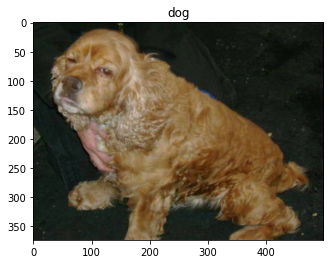

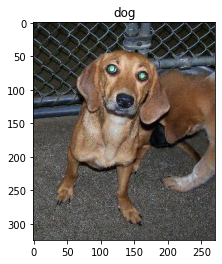

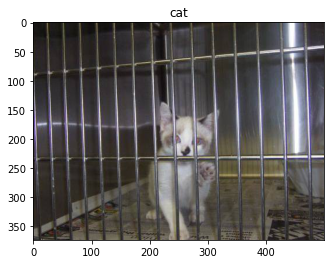

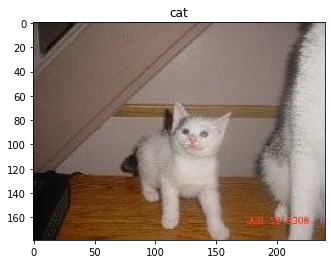

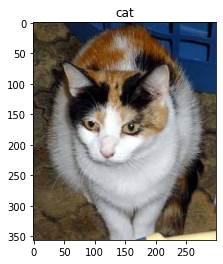

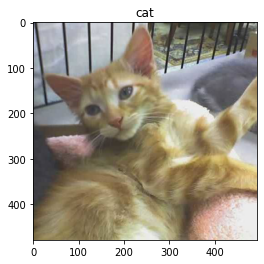

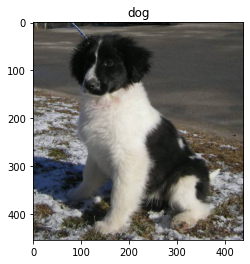

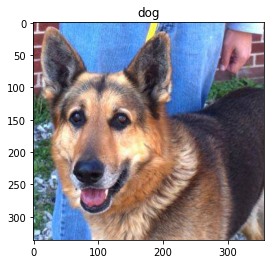

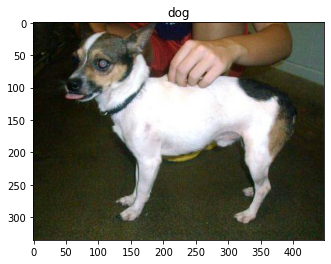

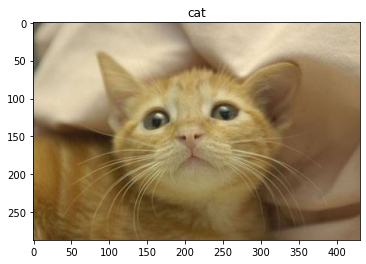

In [6]:
for i in range(10) :
    sample = filenames[i+10]
    image = tf.keras.preprocessing.image.load_img('./train/' + sample)
    plt.imshow(image)
    plt.title('dog' if categories[i+10]==1 else 'cat')
    plt.show()

## Create The Model 

In [7]:
#model 
model = keras.models.Sequential()

##  Conv_1
model.add(keras.layers.Conv2D(32, 3,input_shape = [128, 128, 3], activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_2
model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_3
model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_4
model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Flatten
model.add(keras.layers.Flatten())

## fc_1
model.add(keras.layers.Dense(1024, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))

## fc_2
model.add(keras.layers.Dense(2, activation = 'sigmoid'))

## optimizer and loss
#optimizer = keras.optimizers.RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

2021-10-01 08:16:35.530787: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 08:16:35.533866: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-01 08:16:35.573303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-01 08:16:35.573918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-01 08:16:35.573968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-01 08:16:35.601703: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [8]:
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Data Preparation


1. Encoding labels

In [9]:
df['category'] = df['category'].map({0 : 'cat', 1 : 'dog'})

2. Create Validation Set

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [11]:
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
batch_size = 10

## Train Generator

In [12]:
train_data = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         rescale = 1./255,
                                                         horizontal_flip=True)
train_generator = train_data.flow_from_dataframe(train_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.


## Valid Generator

In [13]:
valid_data = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
                                                         
                                                         
valid_generator = valid_data.flow_from_dataframe(valid_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)


Found 5000 validated image filenames belonging to 2 classes.


## Training Model 

In [14]:
epochs = 30
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-01 08:16:38.663661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-01 08:16:38.667954: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/30


2021-10-01 08:16:39.796256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-01 08:16:40.628330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-01 08:16:40.659331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2000/2000 [==============================] - 143s 68ms/step - loss: 3.2374 - accuracy: 0.6013 - val_loss: 0.5395 - val_accuracy: 0.7488
Epoch 2/30
2000/2000 [==============================] - 134s 67ms/step - loss: 0.5756 - accuracy: 0.7379 - val_loss: 1.2868 - val_accuracy: 0.7440
Epoch 3/30
2000/2000 [==============================] - 134s 67ms/step - loss: 0.5389 - accuracy: 0.7750 - val_loss: 0.4209 - val_accuracy: 0.8380
Epoch 4/30
2000/2000 [==============================] - 134s 67ms/step - loss: 0.4881 - accuracy: 0.7989 - val_loss: 0.5847 - val_accuracy: 0.7294
Epoch 5/30
2000/2000 [==============================] - 134s 67ms/step - loss: 0.4577 - accuracy: 0.8166 - val_loss: 1.2493 - val_accuracy: 0.8312
Epoch 6/30
2000/2000 [==============================] - 135s 67ms/step - loss: 0.4383 - accuracy: 0.8287 - val_loss: 0.3727 - val_accuracy: 0.8586
Epoch 7/30
2000/2000 [==============================] - 134s 67ms/step - loss: 0.4187 - accuracy: 0.8344 - val_loss: 0.3562 - val

## Saving Parameters

In [15]:
model.save_weights("model.h5")

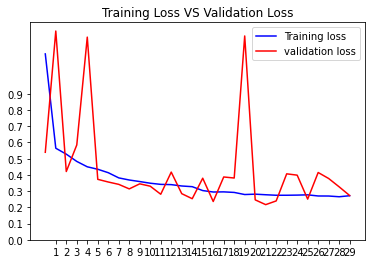

In [16]:
import numpy as np
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

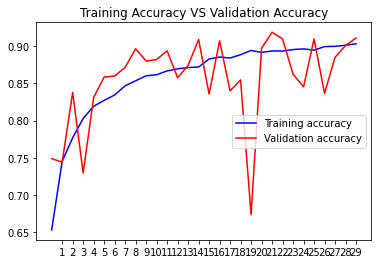

In [17]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

## Prepaing Test Data

In [18]:
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as z :
    z.extractall()

In [19]:
filenames = os.listdir("./test1")
test_df = pd.DataFrame({'filename' : filenames})    
samples = test_df.shape[0]

In [20]:
test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=[128,128],
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [21]:
predict = model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [23]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)